In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 1s 0us/step


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving elephant.jpg to elephant.jpg


In [ ]:
img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02504013', 'Indian_elephant', 0.6433118), ('n02437312', 'Arabian_camel', 0.29499286), ('n01871265', 'tusker', 0.030688522)]


In [ ]:
model.output

<tf.Tensor 'predictions/Softmax:0' shape=(None, 1000) dtype=float32>

In [2]:
!pip install -q transformers tensorflow_datasets
from transformers import TFBertModel
import tensorflow as tf

     |████████████████████████████████| 778kB 5.4MB/s 
     |████████████████████████████████| 3.0MB 91kB/s 
     |████████████████████████████████| 890kB 61.9MB/s 
     |████████████████████████████████| 1.1MB 57.4MB/s 


In [3]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [4]:
vocabulary = tokenizer.get_vocab()

print(list(vocabulary.keys())[5000:5020])

['knight', 'lap', 'survey', 'ma', '##ow', 'noise', 'billy', '##ium', 'shooting', 'guide', 'bedroom', 'priest', 'resistance', 'motor', 'homes', 'sounded', 'giant', '##mer', '150', 'scenes']


In [5]:
max_length_test = 20
test_sentence = 'Test tokenization sentence. Followed by another sentence'
bert_input = tokenizer.encode_plus(
                        test_sentence,                      
                        add_special_tokens = True, # add [CLS], [SEP]
                        max_length = max_length_test, # max length of the text that can go to BERT
                        pad_to_max_length = True, # add [PAD] tokens
                        return_attention_mask = True, # add attention mask to not focus on pad tokens
                        truncation = True
              )

print('encoded', bert_input)

encoded {'input_ids': [101, 3231, 19204, 3989, 6251, 1012, 2628, 2011, 2178, 6251, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [6]:
from transformers import TFBertForSequenceClassification
from transformers import BertConfig

config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True)
bert_model = TFBertModel.from_pretrained("bert-base-uncased", config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [7]:
outputs = bert_model.predict([bert_input["input_ids"], bert_input["token_type_ids"], bert_input["attention_mask"]])

In [8]:
outputs[0].shape

(3, 20, 768)

In [9]:
max_length = 512
batch_size = 6

In [10]:
def convert_example_to_feature(review):
  return tokenizer.encode_plus(review, 
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
                truncation = True
              )

In [11]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds, limit=-1):

  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []

  if (limit > 0):
      ds = ds.take(limit)
    
  for review, label in tfds.as_numpy(ds):

    bert_input = convert_example_to_feature(review.decode())
  
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [12]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load('imdb_reviews', 
          split = (tfds.Split.TRAIN, tfds.Split.TEST),
          as_supervised=True,
          with_info=True)

print('info', ds_info)

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Load pre-computed datasetinfo (eg: splits) from bucket.
INFO:absl:Loading info from GCS for imdb_reviews/plain_text/1.0.0
INFO:absl:Generating dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)


INFO:absl:Downloading http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz into /root/tensorflow_datasets/downloads/ai.stanfor.edu_amaas_sentime_aclImdb_v1PaujRp-TxjBWz59jHXsMDm5WiexbxzaFQkEnXc3Tvo8.tar.gz.tmp.f1212a2bced24c39882e6a90f1d89fba...
INFO:absl:Generating split train


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVVF2SP/imdb_reviews-train.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVVF2SP/imdb_reviews-train.tfrecord. Shard lengths: [25000]
INFO:absl:Generating split test


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVVF2SP/imdb_reviews-test.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVVF2SP/imdb_reviews-test.tfrecord. Shard lengths: [25000]
INFO:absl:Generating split unsupervised


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVVF2SP/imdb_reviews-unsupervised.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVVF2SP/imdb_reviews-unsupervised.tfrecord. Shard lengths: [50000]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.AUTO.
INFO:absl:Constructing tf.data.Dataset for split (NamedSplit('train'), NamedSplit('test')), from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
info tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, A

In [13]:
ds_train_encoded = encode_examples(ds_train).shuffle(10000).batch(batch_size)
ds_test_encoded = encode_examples(ds_test).batch(batch_size)

In [14]:
for review, label in tfds.as_numpy(ds_train.take(5)):
    print('review', review.decode()[0:350], label)

review This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the  0
review I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, b 0
review Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marsha

In [15]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [16]:
vocabulary = tokenizer.get_vocab()
print(list(vocabulary.keys())[5000:5020])

['knight', 'lap', 'survey', 'ma', '##ow', 'noise', 'billy', '##ium', 'shooting', 'guide', 'bedroom', 'priest', 'resistance', 'motor', 'homes', 'sounded', 'giant', '##mer', '150', 'scenes']


In [25]:
learning_rate = 2e-5
number_of_epochs = 10

bert_model.trainable = False

#bert_model.predict([bert_input["input_ids"], bert_input["token_type_ids"], bert_input["attention_mask"]])
input_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32)
input_token = tf.keras.Input(shape=(max_length,), dtype=tf.int32)
input_attention = tf.keras.Input(shape=(max_length,), dtype=tf.int32)
#inputs = {"input_ids": input_ids, "token_type_ids" : input_token, "attention_mask": input_attention}
bert_out = bert_model(inputs = {"input_ids": input_ids, "token_type_ids" : input_token, "attention_mask": input_attention})[0]
#flat = tf.keras.layers.Flatten()(bert_out)
pooling = tf.keras.layers.GlobalAveragePooling1D()(bert_out)
normalization = tf.keras.layers.BatchNormalization()(pooling)
outputs = tf.keras.layers.Dense(units=2, activation='softmax')(normalization)

model = tf.keras.Model(inputs = {"input_ids": input_ids, "token_type_ids" : input_token, "attention_mask": input_attention}, outputs = outputs)

#model = tf.keras.Sequential([
#    bert_model[0][:, 0, :],
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(2, activation='softmax')
#])

# classifier Adam recommended
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [28]:
train_history = model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_test_encoded)

Epoch 1/10
4167/4167 [==============================] - ETA: 0s - loss: 0.6517 - accuracy: 0.6117

KeyboardInterrupt: ignored

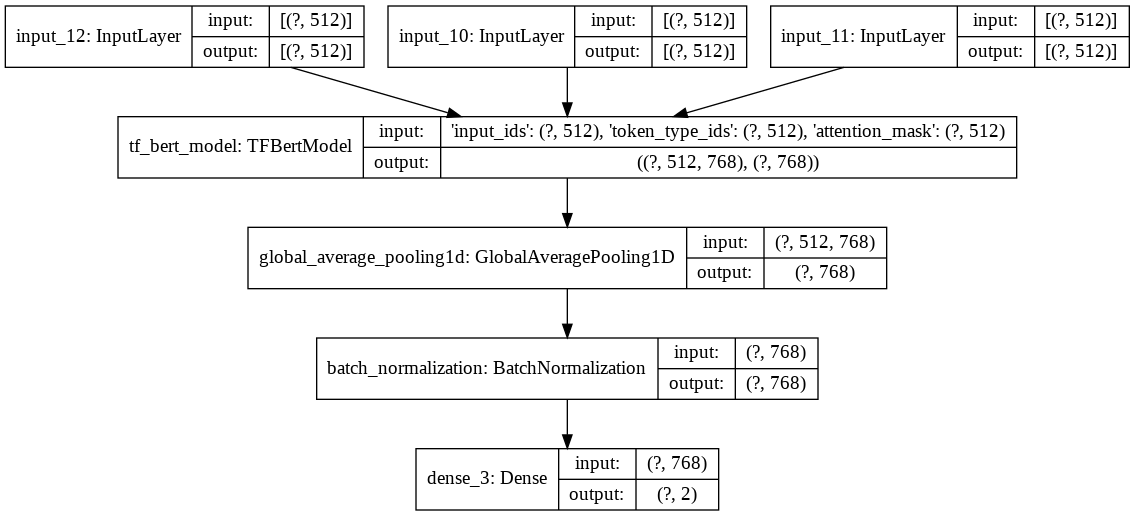

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [27]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 512, 768), ( 109482240   input_12[0][0]                   
                                                                 input_10[0][0]        

In [ ]:
# Propuesta para generar el modelo de BERT

def main_model():
  encoder = ppd.TFBertModel.from_pretrained("bert-base-uncased")
  input_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
  token_type_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
  attention_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)

  embedding = encoder(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

  pooling = tf.keras.layers.GlobalAveragePooling1D()(embedding)
  normalization = tf.keras.layers.BatchNormalization()(pooling)
  dropout = tf.keras.layers.Dropout(0.1)(normalization)

  out = tf.keras.layers.Dense(1, activation="sigmoid", name="final_output_bert")(dropout)

  model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)

  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  optimizer = tf.keras.optimizers.Adam(lr=2e-5)
  metrics=['accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()]

  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  return model

model = main_model()
model.summary()

In [ ]:
# Propuesta para generar el modelo de imagenes

pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Para concatenar la salida de dos modelos

mergedOut = tf.keras.layers.Concatenate()([model1.output,model2.output])